# Finger detection and classification

---


## Notebook configuration
Configure several notebook configuration settings.

In [1]:
# Disable some warnings

import warnings

warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = FutureWarning)

# Use full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

### Libraries / Packages
Import several useful packages for the notebook and configure some extra options.

In [0]:
import os
import cv2
import copy
import numpy as np

from tqdm.notebook import tqdm
from types import SimpleNamespace

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

### Data preparation

Unzip training and validation folders and read and store all image ids.

In [0]:
%%capture

!unzip Training-Dataset.zip
!unzip Validation-Dataset.zip

In [3]:
# Define paths
train_root = './Training-Dataset'
valid_root = './Validation-Dataset'

# Obtain image ids
train_ids = [im[:-4] for im in next(os.walk(f'{train_root}/Images'))[2] if im.endswith('.jpg')]          
valid_ids = [im[:-4] for im in next(os.walk(f'{valid_root}/Images'))[2] if im.endswith('.jpg')]            
          
print(f'Number of images in the Train Dataset = {len(train_ids)}')
print(f'Number of images in the Valid Dataset = {len(valid_ids)}')

Number of images in the Train Dataset = 60
Number of images in the Valid Dataset = 46


## Skin pixels detection using bi-chromatic histograms

Define some utility functions:

In [0]:
def computeHistogram(image, channels, n_bins):
    """Compute 3d-histogram for a given image.
    ----------
    PARAMETERS
    - image: (numpy.ndarray) we assume the image has 3 input channels (RGB, YCbCr, ...)
    - channels: (array) croma channel indices for specific color space
    - n_bins: (int) number of bins for the histogram
    ----------
    RETURNS
    - histogram of croma channels computed jointly and independently
    
    """
    # Bi-dimensional histogram of chroma channels
    bidimensional = \
        cv2.calcHist([image], channels, mask=None, histSize=[n_bins, n_bins], ranges=[0, 256, 0, 256])
    
    # Histogram for each croma channel computed independently
    croma1, croma2 = \
        cv2.calcHist([image], [channels[0]], mask=None, histSize=[n_bins], ranges=[0, 256]), \
        cv2.calcHist([image], [channels[1]], mask=None, histSize=[n_bins], ranges=[0, 256])

    return bidimensional, croma1.ravel(), croma2.ravel()


def plotHistograms(BI, H1, H2, focus=False):
    """Beautiful display for a given bidimensional histogram
    ----------
    PARAMETERS
    - BI: (numpy.ndarray) bi-dimensional histogram
    - H1, H2: (numpy.array) uni-dimensional histograms
    - focus: (bool) zoom in nonzero components of histograms
    ----------
    RETURNS
    - plt.show()
    
    """
    # If focus is set to True, zoom in the non-zero elements of the histograms
    if focus:
        nonzeros0 = np.nonzero(H1)[0]
        nonzeros1 = np.nonzero(H2)[0]
        s0, e0 = nonzeros0[0], nonzeros0[-1] + 1
        s1, e1 = nonzeros1[0], nonzeros1[-1] + 1
        x1 = np.arange(s0, e0)
        x2 = np.arange(s1, e1)
        bi = BI[s0:e0, s1:e1]
        h1 = H1[s0:e0]
        h2 = H2[s1:e1]
    # Else display the whole range of the histogram
    else:
        x1 = x2 = np.arange(len(H1))
        bi = BI; h1 = H1; h2 = H2
    
    plt.figure(figsize=(16, 16))
    # Horizontal bar plot for first chroma channel
    plt.subplot(2, 2, 1)
    plt.barh(x1, h1, height=.5, color="royalblue")
    plt.gca().invert_yaxis()
    plt.xlabel("Normalized pixel probabilities")
    plt.ylabel("Histogram bins")
    # Vertical bar plot for second chroma channel
    plt.subplot(2, 2, 4)
    plt.bar(x2, height=h2, width=.5, color="royalblue")
    plt.xlabel("Histogram bins")
    plt.ylabel("Normalized pixel probabilities")
    # Bi-dimensional histogram as image
    plt.subplot(2, 2, 2)
    plt.imshow(bi, cmap="viridis", aspect="auto")
    plt.axis("off")
    plt.show()
    

def performanceMetrics(predicted, ideal_mask):
    """ Compute accuracy, precision, recall and F1-score for a given mask prediction
    ----------
    PARAMETERS
    - predicted:  (numpy.ndarray) gray-scale predicted mask
    - ideal_mask: (numpy.ndarray) gray-scale ideal mask
    ----------
    RETURNS
    - acc, pre, rec, F1: (float) actual performance metrics for this specific example
    - TP, P, T: (int) for running computations
    
    """
    assert predicted.shape == ideal_mask.shape, "Predicted output is not the same size of ideal mask!"
    
    # Get accuracy, TP, P and T
    acc = np.sum(predicted == ideal_mask).sum() / ideal_mask.size
    TP  = np.sum(predicted + ideal_mask == 0)
    P   = np.sum(predicted == 0)
    T   = np.sum(ideal_mask == 0)
    
    # Compute precision, recall and F1-score
    pre = TP / (P + 1e-06)
    rec = TP / (T + 1e-06)
    F1  = 2 * ((pre * rec) / (pre + rec + 1e-06))
    
    return acc, TP, P, T, pre, rec, F1

In [0]:
def getSkinHistogram(color_space, n_bins=256):
    """Compute skin pixels histogram from training set with defined color_space and number of bins.
    ----------
    PARAMETERS
    - color_space: (str) color space to be used for building the histogram
    - n_bins: (int) number of bins to be used for the histogram
    ----------
    RETURNS
    - BI: (numpy.ndarray) bi-dimensional histogram for chroma channels of specified color space
    - H1, H2: (array) histograms for every chroma channel of specified color space
    
    """
    assert color_space in ["YCbCr", "HSV", "Lab"], "Make sure specified color space is eiter 'YCbCr', 'HSV' or 'Lab'"
    
    if color_space == "YCbCr":
        color_space    = cv2.COLOR_BGR2YCrCb
        croma_channels = [1, 2]
    elif color_space == "HSV":
        color_space    = cv2.COLOR_BGR2HSV
        croma_channels = [0, 1]
    elif color_space == "Lab":
        color_space    = cv2.COLOR_BGR2Lab
        croma_channels = [1, 2]
    
    # We assume the color space has 3 channels
    BI, H1, H2 = np.zeros((n_bins, n_bins)), np.zeros(n_bins), np.zeros(n_bins)
    
    for n, id_ in enumerate(train_ids):
        # Load image and its mask
        img  = cv2.imread(f"{train_root}/Images/{id_}.jpg")
        mask = cv2.imread(f"{train_root}/Masks-Ideal/{id_}.bmp")

        # Convert from BGR to YCbCr color space
        img_YCrCb   = cv2.cvtColor(img, color_space)
        # Extract skin pixels using the ideal masks
        skin_pixels = cv2.subtract(img_YCrCb, mask)

        # Compute histograms for every channel
        bi, h1, h2  = computeHistogram(skin_pixels, channels=croma_channels, n_bins=n_bins)
        # Zero pixels that fall outside of the mask
        bi[0][0] = 0; h1[0] = 0; h2[0] = 0

        # Add normalized histograms to general histograms 
        BI += bi / np.sum(bi + 1e-06)
        H1 += h1 / np.sum(h1 + 1e-06)
        H2 += h2 / np.sum(h2 + 1e-06)
    
    # Return normalized histograms
    return BI / (n + 1), H1 / (n + 1), H2 / (n + 1)

Model histograms with `YCbCr`
 color space and 256 bins (best performing model):

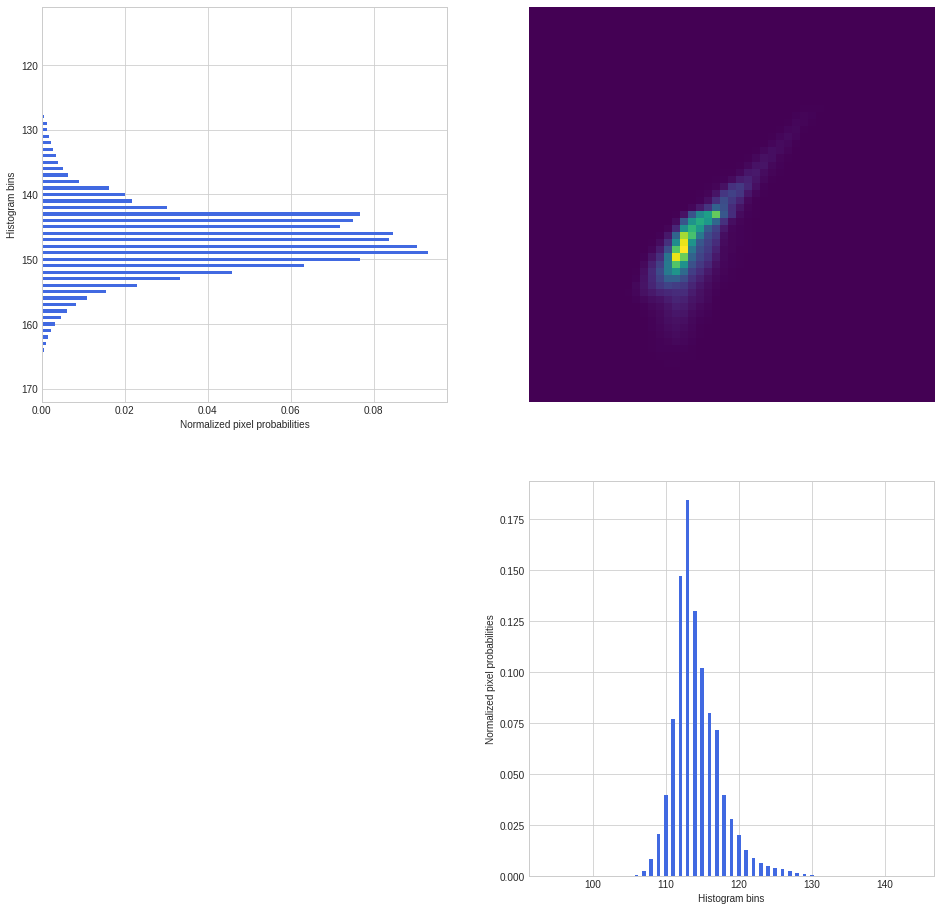

In [6]:
BI, H1, H2 = getSkinHistogram("YCbCr", n_bins=256)

# Beautiful display of the histograms
plotHistograms(BI, H1, H2, focus=True)

In [0]:
def validate(BI, color_space, threshold):
    """Given a pre-computed bi-dimensional model histogram for skin pixels, validate
       its performance with the validation dataset
    ----------
    PARAMETERS
    - BI: (numpy.ndarray) bi-dimensional histogram for chroma channels of specified color space
    - color_space: (str) BI color space
    - threshold: (float) threshold used for the algorithm to determine skin pixels
    ----------
    RETURNS
    - accuracy, precision, recall, F1: (floats) performance metrics on the valid dataset
    - predictions: (dict) contains predicted mask for every image and its corresponding performance metrics
    
    """
    # Define color space tranformation and croma channels
    if color_space == "YCbCr":
        color_space    = cv2.COLOR_BGR2YCrCb
        croma_channels = [1, 2]
    elif color_space == "HSV":
        color_space    = cv2.COLOR_BGR2HSV
        croma_channels = [0, 1]
    elif color_space == "Lab":
        color_space    = cv2.COLOR_BGR2Lab
        croma_channels = [1, 2]
   
    n_bins  = BI.shape[0]
    binning = 256 / n_bins
    
    # Running performance metrics
    run_acc, run_TP, run_P, run_T = .0, .0, .0, .0
    # Dictionary to store all predictions and respective accuracies
    predictions = {}

    for n, id_ in enumerate(valid_ids):
        # Load image and its mask
        img  = cv2.imread(f"{valid_root}/Images/{id_}.jpg")
        mask = cv2.imread(f"{valid_root}/Masks-Ideal/{id_}.bmp", 0)
        # Convert to color space
        img  = cv2.cvtColor(img, color_space)
        
        # Predict on the given image
        prediction = np.full((mask.shape[0], mask.shape[1]), fill_value=255, dtype=np.uint8)
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                c1 = img[i, j, croma_channels[0]]
                c2 = img[i, j, croma_channels[1]]
                if binning > 1:
                    c1 = int(c1 / binning)
                    c2 = int(c2 / binning)
                # Apply threshold
                if BI[c1, c2] >= threshold: prediction[i, j] = 0
        
        # Post-processing morphology 
        strcuturing_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        prediction = cv2.morphologyEx(prediction, cv2.MORPH_OPEN, strcuturing_element, iterations=3)
        # Validate specific prediction
        acc, TP, P, T, pre, rec, f1 = performanceMetrics(prediction, mask)
        #print(f"Accuracy = {acc:.3f}, Precision = {pre:.3f}, Recall = {rec:.3f}, F1-score = {f1:.3f}")
        predictions[id_] = {"prediction" : prediction, "acc" : acc, "f1" : f1}

        run_acc += acc
        run_TP  += TP
        run_P   += P
        run_T   += T
    
    # Collect overall statistics
    accuracy  = run_acc / (n + 1)
    precision = run_TP  / (run_P + 1e-06)
    recall    = run_TP  / (run_T + 1e-06) 
    F1        = 2 *((precision * recall) / (precision + recall + 1e-06))
    
    return accuracy, precision, recall, F1, predictions

Validate our algorithm with the validation dataset and store obtained predictions in order to feed them to the algorithm for the next session. Parameters in the cell below are the ones that provided the best results in our hyper-parameter grid-space optimization (results are shown in the paper attached to the delivery folder).

In [8]:
acc, pre, rec, f1, predictions = validate(BI, "YCbCr", 0.0014)

print(f"Accuracy = {acc:.2f}, Precision = {pre:.2f}, Recall = {rec:.2f}, F1-score = {f1:.2f}") 

Accuracy = 0.97, Precision = 0.95, Recall = 0.92, F1-score = 0.94


Display one good example along with one bad example in order to observe and compare the obtained masks in some of these examples:

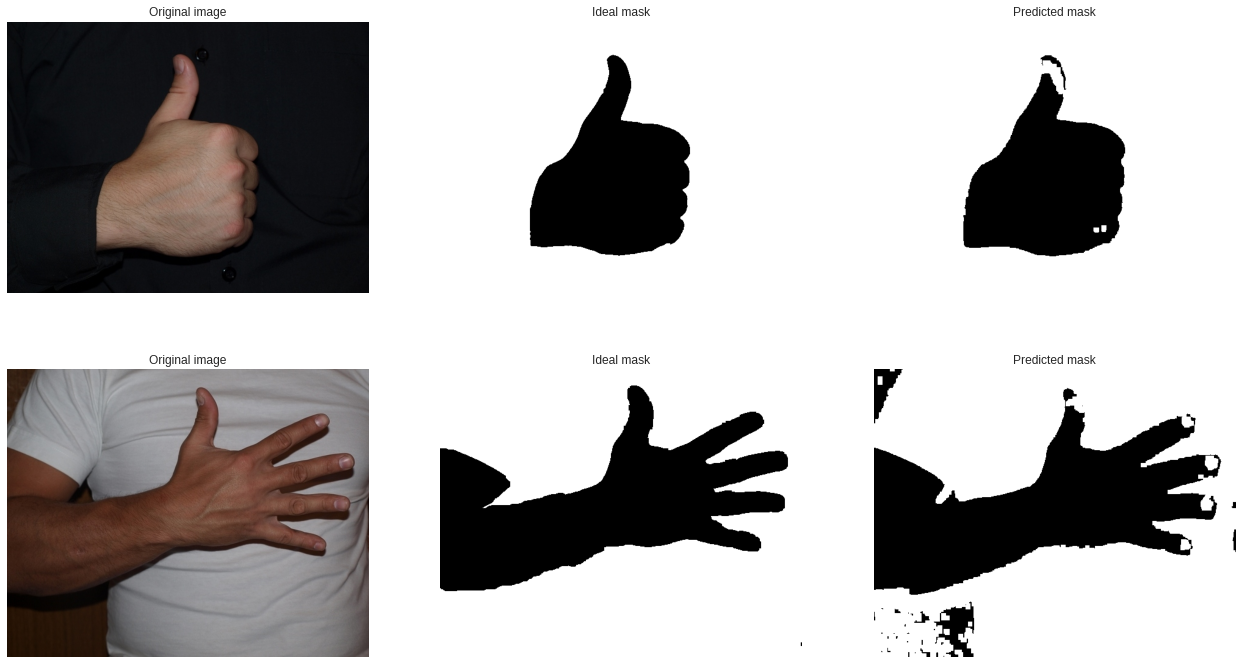

In [9]:
# Manually selected one good example and one bad example
good_example = "1_P_hgr1_id08_3"
bad_example  = "5_P_hgr1_id06_2"


plt.figure(figsize=(22, 12))

# Best example; orginal image
plt.subplot(2, 3, 1)
img = cv2.imread(f"{valid_root}/Images/{good_example}.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Original image")
plt.axis("off")
# Best example; ideal mask
plt.subplot(2, 3, 2)
img = cv2.imread(f"{valid_root}/Masks-Ideal/{good_example}.bmp", 0)
plt.imshow(img, cmap="gray")
plt.title("Ideal mask")
plt.axis("off")
# Best example; predicted mask
plt.subplot(2, 3, 3)
img = predictions[good_example]["prediction"]
plt.imshow(img, cmap="gray")
plt.title("Predicted mask")
plt.axis("off")

# Worst example; original image
plt.subplot(2, 3, 4)
img = cv2.imread(f"{valid_root}/Images/{bad_example}.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Original image")
plt.axis("off")
# Best example; ideal mask
plt.subplot(2, 3, 5)
img = cv2.imread(f"{valid_root}/Masks-Ideal/{bad_example}.bmp", 0)
plt.imshow(img, cmap="gray")
plt.title("Ideal mask")
plt.axis("off")
# Best example; predicted mask
plt.subplot(2, 3, 6)
img = predictions[bad_example]["prediction"]
plt.imshow(img, cmap="gray")
plt.title("Predicted mask")
plt.axis("off")

plt.show()

## Finger Prediction

In order to perform this task, we are goint to take two very different approaches:
- Using Convolutional Neural Networks (CNN)
- Using a fine-tuned algorithm that works with convexity hulls and their defects w.r.t. the contours of the predicted masks.

### CNN

Define a simple Convolutional Neural Network with few convolutional blocks.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
params_cnn = SimpleNamespace(
    # Image size
    HEIGHT   = 256,
    WIDTH    = 256,
    CHANNELS = 3,
    # Network parameters
    N_BLOCKS = 1,
    EPOCHS   = 6,
    BATCH_SIZE = 32,
)

# Define execution environment (device)
if torch.cuda.is_available():
    params_cnn.DEVICE = torch.device("cuda")
else:
    params_cnn.DEVICE = torch.device("cpu")
    print("WARNING! Training without GPU may be very slow!")

#### Data preparation

Hence we cannot use raw data to train our algorithm as we need fixed length input matrices for our model. Here we are going to just use the standard RGB images (not the predicted masks), as we are just trying to prove the point that in this specific case a CNN is not the best option (one could expect the model to perform equally as bad for the other input).

In [0]:
# Define train and validation matrices that will be used by our model
X_train = np.zeros(
    (len(train_ids), params_cnn.HEIGHT, params_cnn.WIDTH, params_cnn.CHANNELS),
    dtype=np.float32)
X_valid = np.zeros(
    (len(valid_ids), params_cnn.HEIGHT, params_cnn.WIDTH, params_cnn.CHANNELS),
    dtype=np.float32)
# Train and validation targets
y_train = np.array([int(id_[0]) for id_ in train_ids], dtype=np.float32)
y_valid = np.array([int(id_[0]) for id_ in valid_ids], dtype=np.float32)


for n, id_ in enumerate(train_ids):
    # Load images
    img = cv2.imread(f"{train_root}/Images/{id_}.jpg")
    # Resize images to the desired shape
    img = cv2.resize(img, (params_cnn.HEIGHT, params_cnn.WIDTH))
    # Save normalized images
    X_train[n] = img / 255.0

for n, id_ in enumerate(valid_ids):
    # Load images
    img = cv2.imread(f"{valid_root}/Images/{id_}.jpg")
    # Resize images to the desired shape
    img = cv2.resize(img, (params_cnn.HEIGHT, params_cnn.WIDTH))
    # Save normalized images
    X_valid[n] = img / 255.0

#### Model architecture

In [0]:
# Standard convolutional block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        return self.conv(x)

# Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, num_classes, num_blocks):
        super(CNN, self).__init__()
        # Convolution blocks
        self.conv_blocks = nn.ModuleList([
            copy.deepcopy(ConvBlock(3 if i == 0 else 4 * 2**(i - 1), 4 * 2**i))
            for i in range(num_blocks)
        ])
        # Final projection classification layer
        self.final_proj  = nn.Linear(
            (4 * 2**(num_blocks - 1)) * (params_cnn.HEIGHT // 2**num_blocks)**2, num_classes)
        
    def forward(self, x):
        # Forward through all convolutional blocks
        for i in range(len(self.conv_blocks)): x = self.conv_blocks[i](x)
        # Final projection
        x = x.reshape(x.shape[0], -1)
        x = self.final_proj(x)
        
        return x       

#### Training the network

Define some utility functions for training, validation and batch generation:

In [0]:
def batchGenerator(X, y, batch_size=32, shuffle=True):
    nsamples = len(X)
    if shuffle:
        perm = np.random.permutation(nsamples)
    else:
        perm = range(nsamples)
    
    for i in range(0, nsamples, batch_size):
        batch_idx = perm[i:(i + batch_size)]
        if y is not None:
            yield X[batch_idx], y[batch_idx]
        else:
            yield X[batch_idx], None

            
def train(model, criterion, optimizer, X, y, batch_size, device, verbose=False):
    """
    
    """
    model.train()
    # Performance metrics initialization
    total_loss = n_correct = n_images = n_iter = .0
    # Per batch training
    for X, y in batchGenerator(X, y, batch_size, shuffle=True):
        # Get input and target sequences from batch and transform into pytorch tensors
        X = torch.Tensor(X).permute(0, 3, 1, 2).to(device)
        y = torch.tensor(y, dtype=torch.long, device=device)
        # Forward and backward pass
        model.zero_grad()
        output = model(X)
        loss   = criterion(output, y)
        loss.backward()
        optimizer.step()
        # Collect training statistics
        total_loss += loss.item()
        n_correct  += (torch.max(output, 1)[1] == y).sum().item()
        n_images   += y.numel()
        n_iter     += 1
        
        # Print useful information
        if verbose:
            info = f"Train: wpb={n_images // n_iter}, num_updates={n_iter}, " \
                   f"Acc={n_correct / n_images:.3f}, Loss={total_loss / n_images:.3f}"
            print(info)
    
    return total_loss / n_images, n_correct / n_images


def validate(model, criterion, X, y, batch_size, device):
    """
    
    """
    model.eval()
    # Performance metrics initialization
    total_loss = n_correct = n_images = n_iter = .0
    y_pred     = []
    # No trainable parameters
    with torch.no_grad():
        # Per batch training
        for X, y in batchGenerator(X, y, batch_size, shuffle=False):
            # Get input sequence from batch and transform to pytorch tensor
            X = torch.Tensor(X).permute(0, 3, 1, 2).to(device)
            # Forward input to the model
            output = model(X)
            # If target is defined
            if y is not None:
                y    = torch.tensor(y, dtype=torch.long, device=device)
                loss = criterion(output, y)
                # Collect statistics
                total_loss += loss.item()
                n_correct  += (torch.max(output, 1)[1] == y).sum().item()
                n_images   += y.numel()
                n_iter     += 1
            # If no target info is available
            else:
                pred = torch.max(output, 1)[1].detach().to("cpu").numpy()
                y_pred.append(pred)
    
    if y is not None:
        return total_loss / n_images, n_correct / n_images
    else:
        return np.concatenate(y_pred)

Train the model with only the available training data:

In [15]:
model      = CNN(6, params_cnn.N_BLOCKS).to(params_cnn.DEVICE)
optimizer  = torch.optim.Adam(model.parameters())
criterion  = nn.CrossEntropyLoss(reduction="sum")

train_accu = train_loss = []
valid_accu = valid_loss = []

for epoch in range(1, params_cnn.EPOCHS + 1):
    print("-" * 30)
    # Train network
    loss, accu = train(model, criterion, optimizer, X_train, y_train, params_cnn.BATCH_SIZE, params_cnn.DEVICE, verbose=False)
    train_accu.append(accu)
    train_loss.append(loss)
    print()
    print(f"Epoch {epoch:03d} | train accuracy={accu:.3f}, train loss={loss:.3f}")
    # Validate on validation data
    loss, accu = validate(model, criterion, X_valid, y_valid, params_cnn.BATCH_SIZE, params_cnn.DEVICE)
    valid_accu.append(accu)
    valid_loss.append(loss)
    print(f"Epoch {epoch:03d} | valid accuracy={accu:.3f}, valid loss={loss:.3f}")

------------------------------

Epoch 001 | train accuracy=0.133, train loss=12.776
Epoch 001 | valid accuracy=0.217, valid loss=2.240
------------------------------

Epoch 002 | train accuracy=0.183, train loss=23.252
Epoch 002 | valid accuracy=0.217, valid loss=2.137
------------------------------

Epoch 003 | train accuracy=0.367, train loss=18.499
Epoch 003 | valid accuracy=0.196, valid loss=2.815
------------------------------

Epoch 004 | train accuracy=0.317, train loss=18.712
Epoch 004 | valid accuracy=0.283, valid loss=2.448
------------------------------

Epoch 005 | train accuracy=0.483, train loss=10.032
Epoch 005 | valid accuracy=0.304, valid loss=2.071
------------------------------

Epoch 006 | train accuracy=0.600, train loss=5.798
Epoch 006 | valid accuracy=0.174, valid loss=2.590


##### Image augmentation

Hence how our model performed very poorly... we are going to try to increase its performance by means of image augmentation.

In order to do that, we are going to apply random transformations to images in the training dataset such as rotation, translation and blurring.

In [0]:
def rotate(img, clockwise=True, scale=1.0):
    # Grab dimensions of the image and determine the center
    h, w   = img.shape[:2]
    cX, cY = w // 2, h // 2
    # Grab the rotation matrix, then grab the sine and cosine
    # (i.e. the rotation components of the matrix)
    angle = np.random.randint(0, 360)
    angle = -angle if clockwise else angle
    M     = cv2.getRotationMatrix2D((cX, cY), angle, scale)
    cos   = np.abs(M[0, 0])
    sin   = np.abs(M[0, 1])
    # Compute new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
       
    # Perform the actual rotation and return the image
    return cv2.warpAffine(img, M, (nW, nH))


###


def clockwiseRotation(img, scale=1.0):
    # Grab dimensions of the image and determine the center
    h, w   = img.shape[:2]
    cX, cY = w // 2, h // 2
    # Grab the rotation matrix, then grab the sine and cosine
    # (i.e. the rotation components of the matrix)
    angle = -np.random.randint(0, 360)
    M     = cv2.getRotationMatrix2D((cX, cY), angle, scale)
    # Perform the actual rotation and return the image
    return cv2.warpAffine(img, M, (w, h))

def anticlockwiseRotation(img, scale=1.0):
    # Grab dimensions of the image and determine the center
    h, w   = img.shape[:2]
    cX, cY = w // 2, h // 2
    # Grab the rotation matrix, then grab the sine and cosine
    # (i.e. the rotation components of the matrix)
    angle = np.random.randint(0, 360)
    M     = cv2.getRotationMatrix2D((cX, cY), angle, scale)
    # Perform the actual rotation and return the image
    return cv2.warpAffine(img, M, (w, h))

def vFlip(img):
    return cv2.flip(img, flipCode=0)

def hFlip(img):
    return cv2.flip(img, flipCode=1)

def blurImage(img):
    return cv2.GaussianBlur(img, (11, 11), 0)

Generate 1000 extra augmented images with the previously defined utility functions:

In [24]:
X_train_augmented = copy.deepcopy(X_train)
y_train_augmented = copy.deepcopy(y_train)

images_to_generate = 1000

aux = np.zeros((images_to_generate, X_train.shape[1], X_train.shape[2], X_train.shape[3]), dtype=np.uint8)

X_train_augmented = np.append(X_train_augmented, aux, axis=0)

transformations = {
    "clockwise_rotation"     : clockwiseRotation,
    "anticlockwise_rotation" : anticlockwiseRotation,
    "vflip" : vFlip,
    "hflip" : hFlip,
    "blur"  : blurImage,
}

for i in tqdm(range(images_to_generate)):
    # Select a random image to be transformed
    idx   = np.random.randint(0, len(X_train))
    label = y_train[idx]
    img   = X_train_augmented[idx]
    img_transformed = copy.deepcopy(img)

    # Number of transformations to be applied to img
    n_transforms = np.random.randint(1, 6)
    for _ in range(n_transforms):
        # Randomly choose method to call
        transform       = np.random.choice(list(transformations))
        transformed_img = transformations[transform](img_transformed)
    
    # Append generated image to main matrix
    X_train_augmented[i + len(X_train)] = transformed_img #np.append(X_train_augmented, np.expand_dims(transformed_img, axis=0), axis=0)
    y_train_augmented = np.append(y_train_augmented, label)

Plot several examples of the previous transformations. Hence how they appear blurred, flipped and/or rotated depending on the generated samples:

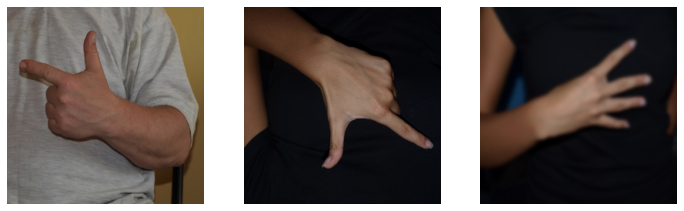

In [25]:
# Display three random augmented images from the dataset
plt.figure(figsize=(12, 10))
plt.subplot(1, 3, 1)
img = X_train_augmented[np.random.randint(60, len(X_train_augmented))]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 3, 2)
img = X_train_augmented[np.random.randint(60, len(X_train_augmented))]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 3, 3)
img = X_train_augmented[np.random.randint(60, len(X_train_augmented))]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Train the same model with exactly the same parameters with the augmented dataset:

In [26]:
model      = CNN(6, params_cnn.N_BLOCKS).to(params_cnn.DEVICE)
optimizer  = torch.optim.Adam(model.parameters())
criterion  = nn.CrossEntropyLoss(reduction="sum")

train_accu = train_loss = []
valid_accu = valid_loss = []

for epoch in range(1, params_cnn.EPOCHS + 1):
    print("-" * 30)
    # Train network
    loss, accu = train(model, criterion, optimizer, X_train_augmented, y_train_augmented, params_cnn.BATCH_SIZE, params_cnn.DEVICE, verbose=False)
    train_accu.append(accu)
    train_loss.append(loss)
    print()
    print(f"Epoch {epoch:03d} | train accuracy={accu:.3f}, train loss={loss:.3f}")
    # Validate on validation data
    loss, accu = validate(model, criterion, X_valid, y_valid, params_cnn.BATCH_SIZE, params_cnn.DEVICE)
    valid_accu.append(accu)
    valid_loss.append(loss)
    print(f"Epoch {epoch:03d} | valid accuracy={accu:.3f}, valid loss={loss:.3f}")

------------------------------

Epoch 001 | train accuracy=0.297, train loss=10.574
Epoch 001 | valid accuracy=0.261, valid loss=6.415
------------------------------

Epoch 002 | train accuracy=0.634, train loss=2.547
Epoch 002 | valid accuracy=0.239, valid loss=8.461
------------------------------

Epoch 003 | train accuracy=0.789, train loss=0.929
Epoch 003 | valid accuracy=0.239, valid loss=5.810
------------------------------

Epoch 004 | train accuracy=0.894, train loss=0.354
Epoch 004 | valid accuracy=0.239, valid loss=7.504
------------------------------

Epoch 005 | train accuracy=0.939, train loss=0.169
Epoch 005 | valid accuracy=0.304, valid loss=8.258
------------------------------

Epoch 006 | train accuracy=0.980, train loss=0.059
Epoch 006 | valid accuracy=0.239, valid loss=6.840


Depending on the initialization and the image augmentation process, the network improves its performance; overall, the most noticeable increase lays in training accuracy, while validation accuracy remains closer to the previously obtained, thus the network does not generalize well. In order to train this task with this very little data using a neural network, one would shurely have to implement more advanced techniques such as Generative Adversarial Networks, for example.

### Convexity Hull Defects Algorithm

As the previous approach did not succeed at all, we are going to try to implement a simpler fine-tuned algorithm (details can be seen in the paper attached in the delivery folder).

In [0]:
def computeDistanceToHull(start, end, far):
    """

    """
    # Parameters of first line
    m1 = (end[1] - start[1]) / (end[0] - start[0] + 1e-06)
    b1 = -m1 * end[0] + end[1]
    # Parameters of perpendicular line
    m2 = -(1 / m1 + 1e-06)
    b2 = -m2 * far[0] + far[1]
    # Find intersection
    x  = (b2 - b1) / (m1 - m2 + 1e-06)
    y  = m1 * x + b1

    # Compute eucl. distance from middle point to intersection
    d  = np.sqrt((x - far[0])**2 + (y - far[1])**2)

    return int(x), int(y), d


def plotDefects(canvas):
    """
    
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(canvas)
    plt.axis("off")
    plt.show()
    

def classifyImage(candidates):
    """
    
    """
    if len(candidates) == 1: return 1
    # Select the lowest point in the image
    candidates = sorted(candidates, key=lambda d: -d[2][1])
    # Check if there is the possibility we have a finger left
    if candidates[0][0][0] < candidates[0][2][0]: return len(candidates)
    # Check if starting point is closer to previous starting point or closer to 'far' point
    if (candidates[0][0][0] - candidates[1][0][0])**2 < 1.25*(candidates[0][0][0] - candidates[0][2][0])**2: return len(candidates) + 1
    else: return len(candidates)


def computeHullDefects(image, plot=False):
    """
    
    """
    # Find the contours for the image
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    length  = len(contours)
    maxArea = -np.inf
    # If various contours are encountered, find and select the biggest one
    if length > 0:
        for i in range(length):
            temp = contours[i]
            area = cv2.contourArea(temp)
            if area > maxArea:
                maxArea = area
                index   = i
        
        res  = contours[index]
        # Compute convex hull of the previous contour
        hull = cv2.convexHull(res)
        # Canvas where elements are going to be drawn
        canvas = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        # Define RGB colors that are going to be used to draw
        green_color, red_color, blue_color = (0, 255, 0), (255, 0, 0), (0, 0, 255)
        # Draw contour and hull
        cv2.drawContours(
            canvas, [res], contourIdx=0, color=green_color, thickness=2)
        cv2.drawContours(
            canvas, [hull], contourIdx=0, color=blue_color, thickness=2)
        
        # Recompute hull w.r.t. main contour and find all convexity defects
        hull    = cv2.convexHull(res, returnPoints=False)
        defects = cv2.convexityDefects(res, hull)
        
        # Recover aproximate lengths of each defect and select N biggest ones 
        # (hence more likely to be defects belonging to finger exposure)
        trajectory_distances = [d[0][3] for d in defects]
        N_largest_indices = sorted(range(len(trajectory_distances)), key=lambda d: -trajectory_distances[d])[:N]
            
        # Build defect candidate list
        candidates = []
        for i in N_largest_indices:
            s, e, f, d = defects[i][0]
            start = tuple(res[s][0])
            end   = tuple(res[e][0])
            far   = tuple(res[f][0])
            # Do not consider extreme defects (hence likely to be part of the forearm)
            # We assume all users are showing the right hand! (because of the dataset)
            if end[0] >= image.shape[0] / 3 and start[0] >= image.shape[0] / 3:
                x, y, dxy = computeDistanceToHull(start, end, far)
                candidates.append([start, end, far, d, dxy])
        
        # Filter out those candidates with very small distance between 'far' point and the hull itself
        # using a kind of running average
        summation = 0
        for i, f in enumerate(sorted(candidates, key=lambda d: -d[4])):
            summation += f[4]
            avg = summation / (i + 1)
            cv2.circle(canvas, f[2], radius=8, color=red_color, thickness=-1)
            if i < len(candidates) - 1:
                next_one = candidates[i + 1]
                if avg > next_one[4] * 2:
                    if i == 0 and f[2][0] < f[0][0] and f[2][1] > f[0][1] and next_one[4] * 3 > avg: continue
                    break
        
        if plot: plotDefects(canvas)

        # Final classification (post-processing style)   
        return classifyImage(candidates[:(i+1)])
    

In [28]:
N, correct1, correct2 = 6, 0, 0

for n, id_ in enumerate(valid_ids):
    # 
    mask_ideal  = cv2.bitwise_not(cv2.imread(f"{valid_root}/Masks-Ideal/{id_}.bmp", 0))
    mask_pred   = cv2.bitwise_not(predictions[id_]["prediction"])
    count_ideal = computeHullDefects(copy.deepcopy(mask_ideal), plot=False)
    count_pred  = computeHullDefects(copy.deepcopy(mask_pred), plot=False)
    
    if count_ideal == int(id_[0]): correct1 += 1
    if count_pred  == int(id_[0]): correct2 += 1
                    
accuracies = f"Accuracy on ideal masks: {correct1 / (n + 1) * 100:.2f}%\n" \
             f"Accuracy on predicted masks: {correct2 / (n + 1) * 100:.2f}%"

print(accuracies)

Accuracy on ideal masks: 100.00%
Accuracy on predicted masks: 84.78%


Hence how the fundamentals of the algorithm are clear, and it achieves a 100% accuracy on the perfect masks. It cannot achieve such a high accuracy with the predicted outputs of the previous section, as they present some irregularities (for example with the nails) and thus the algorithm can struggle with contour detection.
